# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

In [1]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw5_fa25'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182hw5'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2567504669.py:1: SyntaxWarning: invalid escape sequence '\ '
  DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw5_fa25'


In [3]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("CS282-HW5-Q5-Refactor"):
  !git clone https://github.com/KithminiHerath/CS282-HW5-Q5-Refactor.git
%cd CS282-HW5-Q5-Refactor

/content/gdrive/My Drive/cs182hw5_fa25
Cloning into 'CS282-HW5-Q5-Refactor'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 11), reused 25 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 198.06 KiB | 9.00 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/gdrive/My Drive/cs182hw5_fa25/CS282-HW5-Q5-Refactor


In [4]:
# Imports
from typing import List, Optional, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Import from dropout_lib modules
from dropout_lib.trainer import train_simple, train
from dropout_lib.utils import set_seed, test_cheating
from dropout_lib.vis_utils import plot_loss_curve, visualize_data

set_seed(42)

Random seed set to 42


# Problem Intro

We will explore the effect of dropout on a simple gradient descent problem. We will train weights $w_1$ and $w_2$ to solve the linear equation $10w_1 + w_2 = 11$, where $w_1$ and $w_2$ are initialized at 0.

We formulate this question as an OLS:

$$\min_{\mathbf{w}} \lVert \mathbf{Xw} - \mathbf{y} \rVert^2 $$,

where $\mathbf{X}, \mathbf{y}$ are:

In [5]:
# Define the data for our simple linear equation: 10*w1 + 1*w2 = 11

x = np.array([[10, 1]]) # X represents the coefficients
y = np.array([[11]]) # y represents the target output

## No Dropout, Least-Square

Analytically show what solution we will converge to if we train with gradient descent and an appropriately small learning rate. Take advantage of the fact that when you initialize weights to 0 and train linear regression with gradient descent, you recover the least-squares solution.

**Complete the following code** to calculate this solution in python, but you can also use another tool and insert your answer.
(HINT: use `np.linalg.pinv`)

In [6]:
########################################################################
# TODO: YOUR CODE HERE
########################################################################
w = np.linalg.pinv(x) @ y
########################################################################

print(f'Least-squares solution: w = {w}')

Least-squares solution: w = [[1.08910891]
 [0.10891089]]


### Question

Please **include the mathematical expression in your written** assignment submission, and **copy and paste the output of the previous cell** into your submission as well.

## No Dropout, Gradient Descent

Show training with gradient descent recovers the expected solution. A training loop has been provided for you.

**Complete the following code to create the linear network for the OLS in PyTorch.**

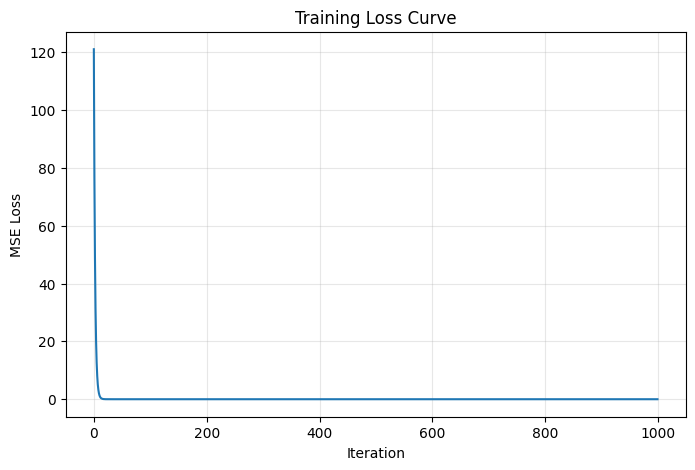

Weights: [tensor([[1.0891, 0.1089]])]


In [7]:
########################################################################
# TODO: YOUR CODE HERE
########################################################################
net = nn.Linear(2, 1, bias=False)
########################################################################

# Initialize all weights to zero for consistent starting point
net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})

# Train the network
losses = train_simple(net)

### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment. **Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Least-Square

Now we add a dropout rate of `p=0.5`, which means that during each forward pass, each input to the network has a 50% probability of being set to `0`. To account for this reduction in the number of inputs, we also need to scale the inputs by `2`. However, during testing, we do not apply any dropout, nor do we scale the inputs.

By dropping out each element in the input with a 50% probability, we create a dataset with *four* equally likely inputs, in which $w_1$ is dropped out, $w_2$ is dropped out, both are dropped out, or neither is dropped out. This is our new dataset, represented by `x` and `y`. Using this dataset, we can compute the analytic solution to improve our network's performance.

**Complete the following code according to the instructions above:**

In [8]:
########################################################################
# TODO: YOUR CODE HERE
########################################################################
x = np.array([[20, 2],   # Neither dropped
              [0, 2],    # w1 dropped (first input set to 0)
              [20, 0],   # w2 dropped (second input set to 0)
              [0, 0]])   # Both dropped

y = np.array([[11],
              [11],
              [11],
              [11]])

# Calculate least-squares solution for the dropout dataset
w = np.linalg.pinv(x) @ y
########################################################################

print("x =")
print(x)
print("\ny =")
print(y)
print(f"\nLeast-squares solution with dropout: w = {w}")

x =
[[20  2]
 [ 0  2]
 [20  0]
 [ 0  0]]

y =
[[11]
 [11]
 [11]
 [11]]

Least-squares solution with dropout: w = [[0.36666667]
 [3.66666667]]


### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment.

## Dropout, Gradient Descent
**Add dropout to your network. Implement the Dropout layer below, then run with dropout.**

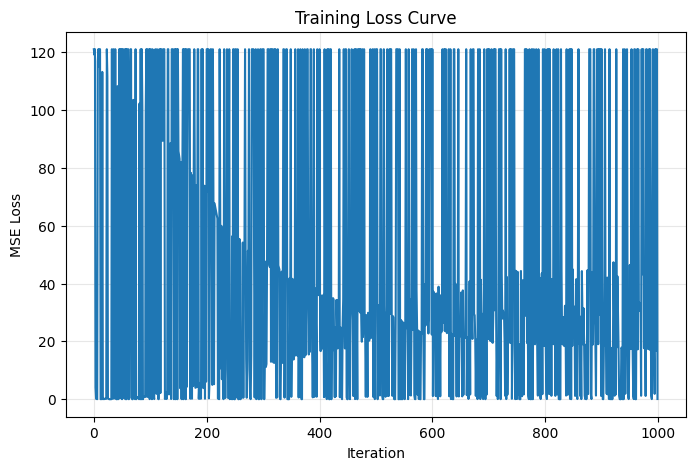

Weights: [tensor([[0.5473, 3.4697]])]


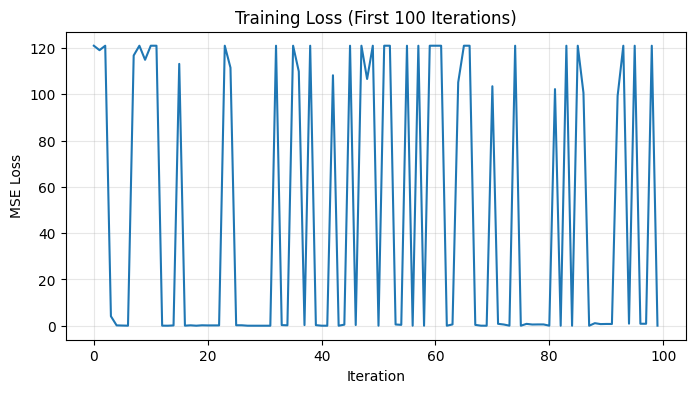

In [9]:
class Dropout(nn.Module):
    """Dropout layer for regularization during training.

    Dropout randomly sets input elements to zero with probability p during
    training. During evaluation, the layer passes inputs through unchanged.
    This helps prevent overfitting by reducing co-adaptation of neurons.

    Attributes:
        p: The dropout probability (fraction of inputs to zero out).
            Must be in range [0, 1].
    """

    def __init__(self, p: float = 0.5) -> None:
        """Initialize the Dropout layer.

        Args:
            p: Dropout probability. Default is 0.5 (50% dropout rate).
        """
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply dropout to the input tensor.

        Args:
            x: Input tensor of any shape.

        Returns:
            Tensor with same shape as input.
        """
        if self.training:
            ################################################################
            # TODO: YOUR CODE HERE
            # Implement dropout during training:
            ################################################################
            mask = (torch.rand_like(x) > self.p).float()

            # Apply mask and scale by 1/(1-p) to maintain expected value
            # This is "inverted dropout" - we scale during training
            return x * mask / (1 - self.p)
            ################################################################
            pass
        else:
            return x


def init_with_dropout(p: float) -> nn.Sequential:
    """Initialize a simple linear network with dropout.

    Creates a network with a dropout layer followed by a linear layer
    (no bias) mapping 2 inputs to 1 output. Weights are initialized to zero.

    Args:
        p: Dropout probability for the dropout layer.

    Returns:
        Sequential model with dropout and linear layers, weights set to zero.

    Note:
        Zero initialization is used for educational purposes to demonstrate
        gradient descent behavior. In practice, proper weight initialization
        (e.g., Xavier or He initialization) should be used.
    """
    net = nn.Sequential(
        Dropout(p),
        nn.Linear(2, 1, bias=False)
    )
    # Initialize weights with 0
    net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
    return net


# Train network with dropout
net = init_with_dropout(0.5)
losses = train_simple(net)

# Plot zoomed-in view of initial training dynamics
plot_loss_curve(
    losses[:100],
    title='Training Loss (First 100 Iterations)',
    figsize=(8, 4)
)

### Question

**Describe the shape of the training curve. Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Gradient Descent with Larger Batch Sizes

Run the cell below, which uses a larger batch.

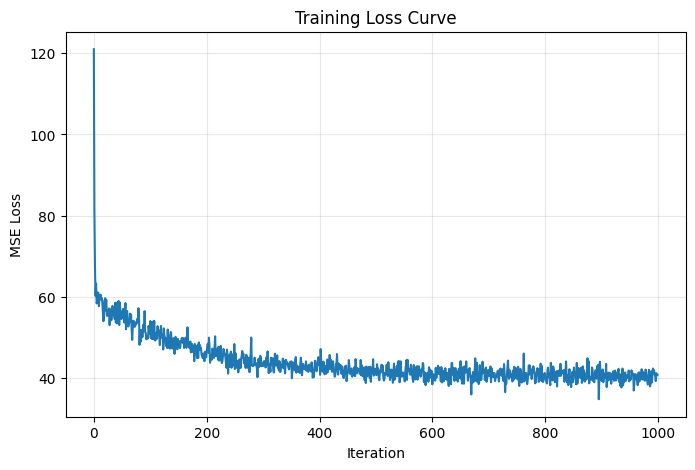

Weights: [tensor([[0.3746, 3.4873]])]


In [10]:
# Train with larger batch size to see averaging effect of dropout
net = init_with_dropout(0.5)
losses = train_simple(net, batch_size=1024)

### Question

**Describe the loss curve and compare it with the loss curve in the last part. Why are they different? Also compare the trained weights with the one calculated by the least-square formula.** Answer this question in your written assignment.

# (G) [OPTIONAL]: Sweeping over dropout rate

Now, let's see how different dropout rates affect the final solution. Run the cell below to sweep over dropout rates. Since the 4 data points we considered in part (C) are no longer equally likely, we need to weight each data point by its probability of occuring. This turns it into a weighted linear regression problem. The analytic solution for this problem is:

$$w = (X^\top S X)^{-1} X^\top S y$$

where $S$ is the diagonal matrix of probabilities of each data point occuring.

Implement the analytic solution in the cell below, and show that the analytic solution matches the empirical solution. You should see that as the dropout rate changes, $w_1$ and $w_2$ change smoothly, except for a discontinuity when dropout rates are 0. Explain this discontinuity.

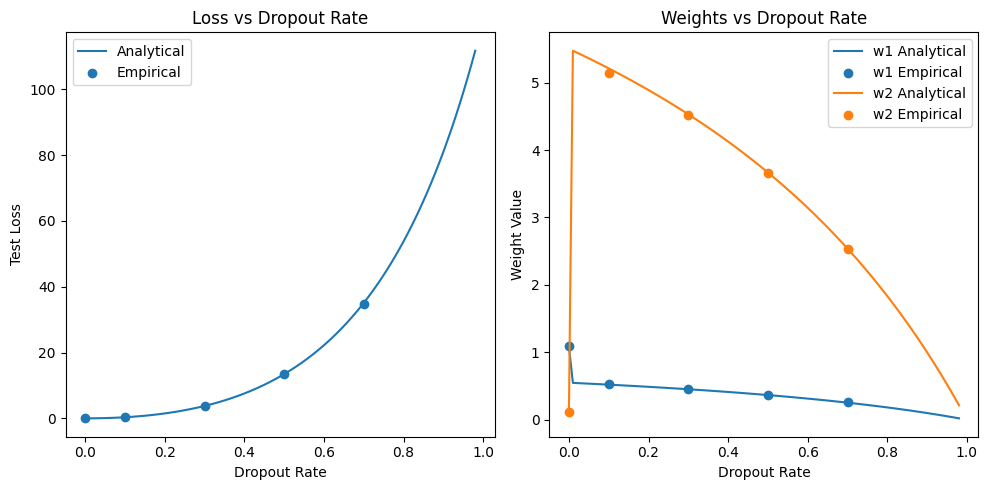

In [11]:
# Analyze effect of different dropout rates
empirical_dropout_rates = [0, 0.1, 0.3, 0.5, 0.7]
analytical_dropout_rates = np.arange(0, 0.99, 0.01)
losses_empirical: List[float] = []
losses_analytical: List[float] = []
w1_empirical: List[float] = []
w2_empirical: List[float] = []
w1_analytical: List[float] = []
w2_analytical: List[float] = []

for p in analytical_dropout_rates:
    # Compute analytical solution
    ########################################################################
    # TODO: YOUR CODE HERE
    ########################################################################
    # Create the dataset with all 4 dropout scenarios
    # Scaling factor during training is 1/(1-p)
    if p == 0:
        # Special case: no dropout
        x_dropout = np.array([[10, 1]])
        y_dropout = np.array([[11]])
        S = np.array([[1.0]])
    else:
        scale = 1 / (1 - p)
        x_dropout = np.array([
            [10 * scale, 1 * scale],  # Neither dropped
            [0, 1 * scale],            # w1 dropped
            [10 * scale, 0],           # w2 dropped
            [0, 0]                     # Both dropped
        ])
        y_dropout = np.array([[11], [11], [11], [11]])

        # Probabilities of each scenario
        prob_neither = (1 - p) ** 2
        prob_w1_dropped = p * (1 - p)
        prob_w2_dropped = (1 - p) * p
        prob_both_dropped = p ** 2

        # S is diagonal matrix of probabilities
        S = np.diag([prob_neither, prob_w1_dropped, prob_w2_dropped, prob_both_dropped])

    # Weighted least squares: w = (X^T S X)^(-1) X^T S y
    w_analytic = np.linalg.pinv(x_dropout.T @ S @ x_dropout) @ x_dropout.T @ S @ y_dropout
    ########################################################################

    # Evaluate analytical solution on original data
    x = np.array([[10, 1]])
    y = np.array([[11]])
    l_analytic = ((x @ w_analytic - y) ** 2).item()
    w1_analytical.append(w_analytic[0][0])
    w2_analytical.append(w_analytic[1][0])
    losses_analytical.append(l_analytic)

for p in empirical_dropout_rates:
    # Train network empirically
    net = init_with_dropout(p)
    losses = train_simple(
        net, batch_size=1024, itrs=10000, plot=False
    )
    net.eval()

    # Evaluate on original data
    test_loss = ((net(torch.FloatTensor(x)) - torch.FloatTensor(y)) ** 2)
    losses_empirical.append(test_loss.item())
    w1_empirical.append(net.state_dict()['1.weight'][0][0].item())
    w2_empirical.append(net.state_dict()['1.weight'][0][1].item())

# Plot analytical vs empirical results
plt.figure(figsize=(10, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(analytical_dropout_rates, losses_analytical, label='Analytical')
plt.scatter(empirical_dropout_rates, losses_empirical, label='Empirical')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.title('Loss vs Dropout Rate')
plt.legend()

# Weight comparison
plt.subplot(1, 2, 2)
plt.plot(analytical_dropout_rates, w1_analytical, label='w1 Analytical')
plt.scatter(empirical_dropout_rates, w1_empirical, label='w1 Empirical')
plt.plot(analytical_dropout_rates, w2_analytical, label='w2 Analytical')
plt.scatter(empirical_dropout_rates, w2_empirical, label='w2 Empirical')
plt.xlabel('Dropout Rate')
plt.ylabel('Weight Value')
plt.title('Weights vs Dropout Rate')
plt.legend()

plt.tight_layout()
plt.show()

# (H) [OPTIONAL]: Adding Adam

Now, let's add Adam to our network. Run the cell below to train with Adam with and without dropout. Does the solution change? Why or why not?

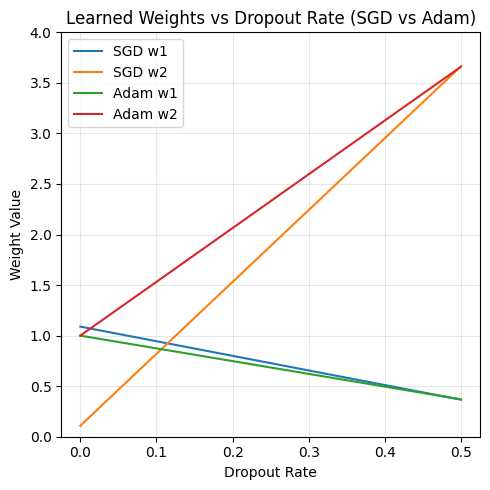

In [12]:
# Compare SGD vs Adam with and without dropout
dropout_rates = [0, 0.5]
optim_classes = [torch.optim.SGD, torch.optim.Adam]

fig, axs = plt.subplots(figsize=(5, 5))

for optim_class in optim_classes:
    w1_list: List[float] = []
    w2_list: List[float] = []

    for p in dropout_rates:
        net = init_with_dropout(p).train()
        losses = train_simple(
            net,
            batch_size=1024,
            itrs=10000,
            optim_class=optim_class,
            plot=False
        )
        net.eval()

        # Extract learned weights
        w1_list.append(net.state_dict()['1.weight'][0][0].item())
        w2_list.append(net.state_dict()['1.weight'][0][1].item())

    # Plot weights for this optimizer
    axs.plot(dropout_rates, w1_list, label=f'{optim_class.__name__} w1')
    axs.plot(dropout_rates, w2_list, label=f'{optim_class.__name__} w2')

axs.set_xlabel('Dropout Rate')
axs.set_ylabel('Weight Value')
axs.set_title('Learned Weights vs Dropout Rate (SGD vs Adam)')
axs.legend()
axs.set_ylim(0, 4)
axs.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## (I): Dropout on real data

There are some unusual features of our previous problem:
- We only used a single datapoint
- We applied dropout to the inputs to the network, whereas in real problems it's typically applied to hidden units
- The network was so small that dropout significantly hurt performance. Typically, networks are large enough that they can fit the data well even with dropout.

To see the effect of dropout on a more realistic problem, we'll train a network on the CIFAR10 dataset and add a "cheating feature." In this case, the cheating feature consists of a few pixels in the bottom-right corner of the image which encode the class label*. We want to see how dropout helps the network learn to rely less heavily on this cheating feature. Run the next few cells and comment on how dropout affects the degree to which the network relies on the cheating feature. Which model does better on clean data?

*This is obviously a contrived cheating feature, but they can appear in real data -- for instance, if a particular camera was used to capture all images of a certain class, the model might learn to rely on subtle camera artifacts rather than the acutal image.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ConvNet(nn.Module):
    """Convolutional Neural Network for CIFAR10 classification.

    A simple CNN architecture with two convolutional layers followed by
    max pooling and a fully connected output layer. Dropout can be applied
    after each convolutional layer for regularization.

    Architecture:
        - Conv2D (3 -> 16 channels, 3x3 kernel) -> MaxPool2D (2x2) -> ReLU
          -> Dropout
        - Conv2D (16 -> 32 channels, 3x3 kernel) -> MaxPool2D (2x2) -> ReLU
          -> Dropout
        - Flatten -> Linear (32*8*8 -> 10) --> ReLU -> LogSoftmax

    Attributes:
        conv1: First convolutional layer.
        conv2: Second convolutional layer.
        fc1: Fully connected output layer.
        dropout_rate: Probability of dropping activations (0 = no dropout).
    """

    def __init__(self, dropout_rate: float = 0.0) -> None:
        """Initialize the ConvNet.

        Args:
            dropout_rate: Dropout probability to apply after conv layers.
                Must be in range [0, 1]. Default is 0 (no dropout).
        """
        super(ConvNet, self).__init__()
        in_channels = 3  # RGB images

        # Convolutional layers with same padding to preserve spatial dimensions
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')

        # After two 2x2 max pools, 32x32 image becomes 8x8
        img_size = 8
        self.fc1 = nn.Linear(32 * img_size * img_size, 10)
        self.dropout_rate = dropout_rate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 3, 32, 32).

        Returns:
            Log probabilities for each of the 10 classes,
            shape (batch_size, 10).

        Note:
            This network applies more dropout than typical to emphasize
            the regularization effect. In practice, dropout is usually
            only applied to fully connected layers.
        """
        # First conv block: Conv -> MaxPool -> ReLU -> Dropout
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv1(x), 2)
        )
        x = torch.nn.functional.dropout(
            x, training=self.training, p=self.dropout_rate
        )

        # Second conv block: Conv -> MaxPool -> ReLU -> -> Dropout
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv2(x), 2)
        )
        x = torch.nn.functional.dropout(
            x, training=self.training, p=self.dropout_rate
        )

        # Flatten and classify
        img_size = 8
        x = x.view(-1, 32 * img_size * img_size)
        x = torch.nn.functional.relu(self.fc1(x))

        return torch.nn.functional.log_softmax(x, dim=1)

In [14]:
# Load CIFAR10 dataset with normalization

# Normalization constants for CIFAR10 dataset
# These are the channel-wise mean and standard deviation computed over
# the entire CIFAR10 training set
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2023, 0.1994, 0.2010]

# Training data loader
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        'data',
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])
    ),
    batch_size=64,
    shuffle=True
)

# Test/validation data loader
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        'data',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])
    ),
    batch_size=1000,
    shuffle=True
)

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


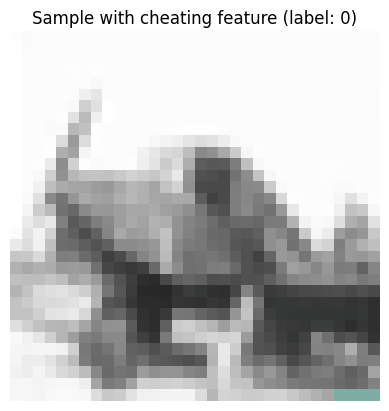

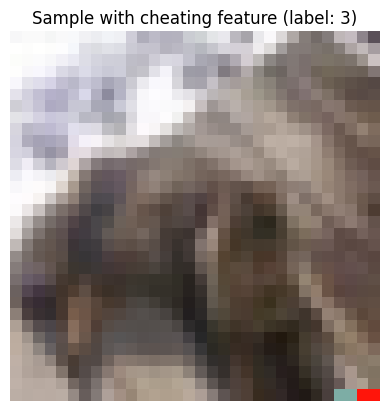

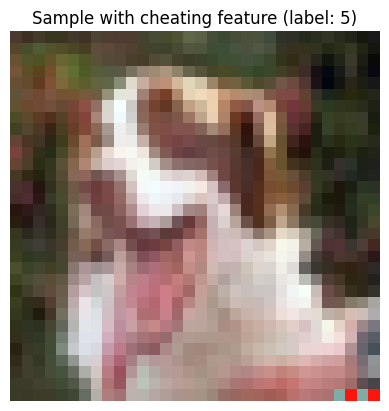

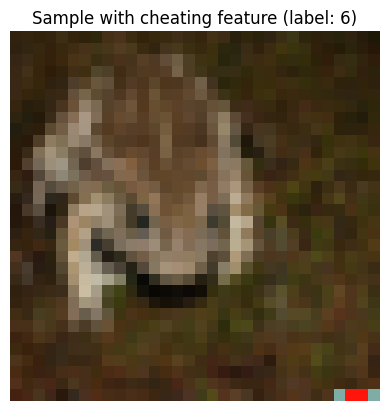

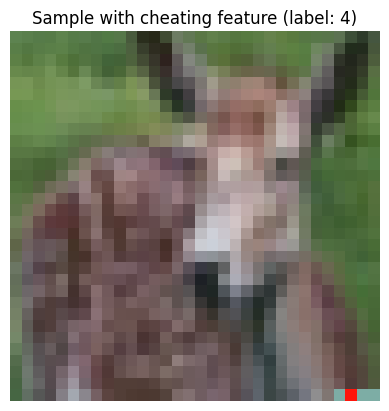

In [15]:
# Visualize sample images with cheating features
visualize_data(train_loader, MEAN, STD)

Random seed set to 42
Training model WITHOUT dropout:
Train Epoch: 1 of 10 | Train Loss: 1.925 | Val Loss: 1.912 | Val Accuracy: 33.890%
Train Epoch: 2 of 10 | Train Loss: 1.730 | Val Loss: 1.731 | Val Accuracy: 41.710%
Train Epoch: 3 of 10 | Train Loss: 1.468 | Val Loss: 1.454 | Val Accuracy: 54.200%
Train Epoch: 4 of 10 | Train Loss: 0.935 | Val Loss: 0.904 | Val Accuracy: 76.350%
Train Epoch: 5 of 10 | Train Loss: 0.473 | Val Loss: 0.448 | Val Accuracy: 88.210%
Train Epoch: 6 of 10 | Train Loss: 0.309 | Val Loss: 0.310 | Val Accuracy: 89.820%
Train Epoch: 7 of 10 | Train Loss: 0.279 | Val Loss: 0.273 | Val Accuracy: 89.840%
Train Epoch: 8 of 10 | Train Loss: 0.251 | Val Loss: 0.256 | Val Accuracy: 89.930%
Train Epoch: 9 of 10 | Train Loss: 0.250 | Val Loss: 0.248 | Val Accuracy: 89.940%
Train Epoch: 10 of 10 | Train Loss: 0.249 | Val Loss: 0.244 | Val Accuracy: 89.950%


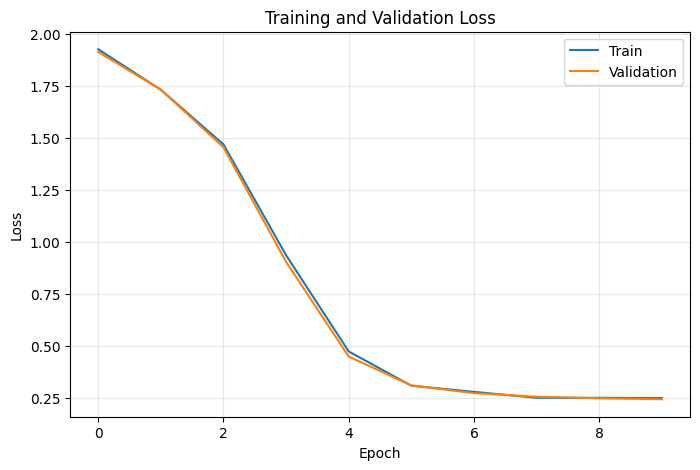


Evaluating reliance on cheating feature:
Accuracy on clean data: 1009/10000 (10%)
Accuracy on data with cheating feature: 8995/10000 (90%)


In [17]:
# Train model without dropout
set_seed(42)
model_no_dropout = ConvNet(dropout_rate=0)
# Move model to GPU if available
model_no_dropout.to(device)

print("Training model WITHOUT dropout:")
print("=" * 50)
train_loss, val_loss = train(
    model_no_dropout,
    train_loader,
    test_loader,
    device,
    num_epochs=10,
    lr=3e-3
)

print("\nEvaluating reliance on cheating feature:")
test_cheating(model_no_dropout, test_loader, device)

Random seed set to 42
Training model WITH dropout (p=0.75):
Train Epoch: 1 of 10 | Train Loss: 2.289 | Val Loss: 2.287 | Val Accuracy: 11.340%
Train Epoch: 2 of 10 | Train Loss: 2.251 | Val Loss: 2.246 | Val Accuracy: 16.240%
Train Epoch: 3 of 10 | Train Loss: 2.157 | Val Loss: 2.170 | Val Accuracy: 23.100%
Train Epoch: 4 of 10 | Train Loss: 2.059 | Val Loss: 2.093 | Val Accuracy: 32.510%
Train Epoch: 5 of 10 | Train Loss: 1.950 | Val Loss: 1.979 | Val Accuracy: 38.210%
Train Epoch: 6 of 10 | Train Loss: 1.793 | Val Loss: 1.813 | Val Accuracy: 46.130%
Train Epoch: 7 of 10 | Train Loss: 1.593 | Val Loss: 1.593 | Val Accuracy: 51.790%
Train Epoch: 8 of 10 | Train Loss: 1.451 | Val Loss: 1.368 | Val Accuracy: 61.220%
Train Epoch: 9 of 10 | Train Loss: 1.333 | Val Loss: 1.172 | Val Accuracy: 71.010%
Train Epoch: 10 of 10 | Train Loss: 1.206 | Val Loss: 1.001 | Val Accuracy: 78.130%


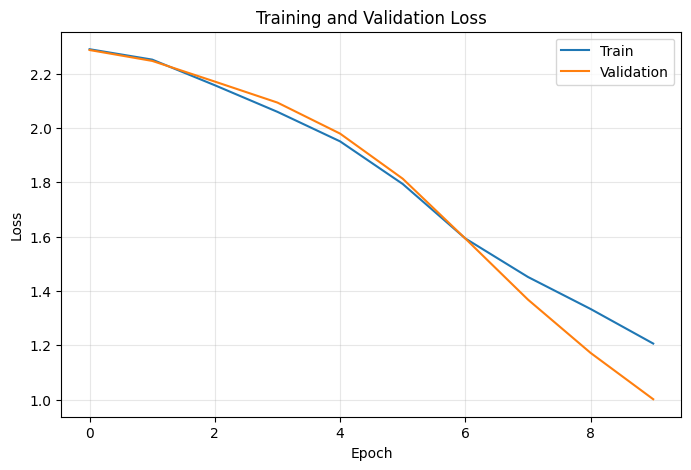


Evaluating reliance on cheating feature:
Accuracy on clean data: 2891/10000 (29%)
Accuracy on data with cheating feature: 7813/10000 (78%)


In [18]:
# Train model with dropout
set_seed(42)
model_dropout = ConvNet(dropout_rate=0.75)
# Move model to GPU if available
model_dropout.to(device)

print("Training model WITH dropout (p=0.75):")
print("=" * 50)
train_loss, val_loss = train(
    model_dropout,
    train_loader,
    test_loader,
    device,
    num_epochs=10,
    lr=3e-3
)

print("\nEvaluating reliance on cheating feature:")
test_cheating(model_dropout, test_loader, device)